In [ ]:
# standard imports
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import joblib

# --- 1) load ---
df = pd.read_excel('Data_Train.xlsx')   # adjust path as needed
df.head()


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [2]:
df['Journey_Date']=pd.to_datetime(df['Date_of_Journey'],dayfirst=True,errors='coerce')

df['journey_day']=df['Journey_Date'].dt.day
df['journey_month']=df['Journey_Date'].dt.month
df['journey_year']=df['Journey_Date'].dt.year

df['dep_hour']=df['Dep_Time'].str.split(':').str[0].astype(int)
df['dep_min']=df['Dep_Time'].str.split(':').str[1].astype(int)

df['arrival_time_only']=df['Arrival_Time'].str.split().str[0]
df['arr_hour']=df['arrival_time_only'].str.split(':').str[0].astype(int)
df['arr_min']=df['arrival_time_only'].str.split(':').str[1].astype(int)


In [3]:
df[['Arrival_Time','arrival_time_only','arr_hour','arr_min']].head()

,Arrival_Time,arrival_time_only,arr_hour,arr_min
0,01:10 22 Mar,01:10,1,10
1,13:15,13:15,13,15
2,04:25 10 Jun,04:25,4,25
3,23:30,23:30,23,30
4,21:35,21:35,21,35


In [4]:
import re
def duration_to_minutes(d):
    if pd.isna(d):
        return np.nan
    #normalize spacing
    d=d.strip().lower()
    hours=0
    mins=0
    h=re.search(r'(\d+)\s*h',d)
    m=re.search(r'(\d+)\s*m',d)
    if h:
        hours=int(h.group(1))
    if m:
        mins=int(m.group(1))
    return int(hours*60 + mins)
df['duration_mins']=df['Duration'].apply(duration_to_minutes)
df[['Duration','duration_mins']].head()

,Duration,duration_mins
0,2h 50m,170
1,7h 25m,445
2,19h,1140
3,5h 25m,325
4,4h 45m,285


In [5]:
df['duration_mins'].describe()

count    10683.000000
mean       643.093232
std        507.862001
min          5.000000
25%        170.000000
50%        520.000000
75%        930.000000
max       2860.000000
Name: duration_mins, dtype: float64

In [6]:
def stops_to_int(x):
    if pd.isna(x): return np.nan
    x=str(x).lower()
    if 'non' in x:
        return 0
    m=re.search(r'(\d+)',x)
    return int(m.group(1)) if m else np.nan
df['total_stops_num']=df['Total_Stops'].apply(stops_to_int)
df[['Total_Stops','total_stops_num']].value_counts().head()

Total_Stops  total_stops_num
1 stop       1.0                5625
non-stop     0.0                3491
2 stops      2.0                1520
3 stops      3.0                  45
4 stops      4.0                   1
Name: count, dtype: int64

In [7]:
# route like "CCU → IXR → BBI → BLR"
df['route_segments'] = df['Route'].str.split('→').apply(lambda x: len(x) if isinstance(x, list) else np.nan)
df[['Route','route_segments']].head()


,Route,route_segments
0,BLR → DEL,2.0
1,CCU → IXR → BBI → BLR,4.0
2,DEL → LKO → BOM → COK,4.0
3,CCU → NAG → BLR,3.0
4,BLR → NAG → DEL,3.0


In [8]:
df['Additional_Info'].value_counts(dropna=False).head(50)  # inspect


Additional_Info
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [9]:
top_info = df['Additional_Info'].value_counts().nlargest(10).index.tolist()
df['add_info_smallcat'] = df['Additional_Info'].apply(lambda x: x if x in top_info else 'Other')
df['add_info_smallcat'].value_counts()

add_info_smallcat
No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Airline            10683 non-null  object        
 1   Date_of_Journey    10683 non-null  object        
 2   Source             10683 non-null  object        
 3   Destination        10683 non-null  object        
 4   Route              10682 non-null  object        
 5   Dep_Time           10683 non-null  object        
 6   Arrival_Time       10683 non-null  object        
 7   Duration           10683 non-null  object        
 8   Total_Stops        10682 non-null  object        
 9   Additional_Info    10683 non-null  object        
 10  Price              10683 non-null  int64         
 11  Journey_Date       10683 non-null  datetime64[ns]
 12  journey_day        10683 non-null  int32         
 13  journey_month      10683 non-null  int32         
 14  journe

In [11]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,journey_year,dep_hour,dep_min,arrival_time_only,arr_hour,arr_min,duration_mins,total_stops_num,route_segments,add_info_smallcat
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,2019,22,20,01:10,1,10,170,0.0,2.0,No info
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,2019,5,50,13:15,13,15,445,2.0,4.0,No info
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,2019,9,25,04:25,4,25,1140,2.0,4.0,No info
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,2019,18,5,23:30,23,30,325,1.0,3.0,No info
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,2019,16,50,21:35,21,35,285,1.0,3.0,No info


In [12]:
df[['journey_day','journey_month','journey_year','dep_hour','dep_min',
    'arr_hour','arr_min','duration_mins','total_stops_num']].isna().sum()


journey_day        0
journey_month      0
journey_year       0
dep_hour           0
dep_min            0
arr_hour           0
arr_min            0
duration_mins      0
total_stops_num    1
dtype: int64

In [13]:
df['total_stops_num'] = df['total_stops_num'].fillna(df['total_stops_num'].mode()[0])

In [14]:
df['total_stops_num'].isna().sum()


np.int64(0)

In [15]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,journey_year,dep_hour,dep_min,arrival_time_only,arr_hour,arr_min,duration_mins,total_stops_num,route_segments,add_info_smallcat
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,...,2019,22,20,01:10,1,10,170,0.0,2.0,No info
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,...,2019,5,50,13:15,13,15,445,2.0,4.0,No info
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,...,2019,9,25,04:25,4,25,1140,2.0,4.0,No info
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,...,2019,18,5,23:30,23,30,325,1.0,3.0,No info
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,...,2019,16,50,21:35,21,35,285,1.0,3.0,No info


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Airline            10683 non-null  object        
 1   Date_of_Journey    10683 non-null  object        
 2   Source             10683 non-null  object        
 3   Destination        10683 non-null  object        
 4   Route              10682 non-null  object        
 5   Dep_Time           10683 non-null  object        
 6   Arrival_Time       10683 non-null  object        
 7   Duration           10683 non-null  object        
 8   Total_Stops        10682 non-null  object        
 9   Additional_Info    10683 non-null  object        
 10  Price              10683 non-null  int64         
 11  Journey_Date       10683 non-null  datetime64[ns]
 12  journey_day        10683 non-null  int32         
 13  journey_month      10683 non-null  int32         
 14  journe

In [17]:
df_clean = df.drop(columns=[
    'Date_of_Journey',
    'Journey_Date',
    'Dep_Time',
    'Arrival_Time',
    'arrival_time_only',
    'Route',
    'Duration',
    'Total_Stops',
    'Additional_Info'
], errors='ignore')


In [18]:
df_clean.shape
df_clean.columns


Index(['Airline', 'Source', 'Destination', 'Price', 'journey_day',
       'journey_month', 'journey_year', 'dep_hour', 'dep_min', 'arr_hour',
       'arr_min', 'duration_mins', 'total_stops_num', 'route_segments',
       'add_info_smallcat'],
      dtype='object')

In [19]:
df_clean.head()

,Airline,Source,Destination,Price,journey_day,journey_month,journey_year,dep_hour,dep_min,arr_hour,arr_min,duration_mins,total_stops_num,route_segments,add_info_smallcat
0,IndiGo,Banglore,New Delhi,3897,24,3,2019,22,20,1,10,170,0.0,2.0,No info
1,Air India,Kolkata,Banglore,7662,1,5,2019,5,50,13,15,445,2.0,4.0,No info
2,Jet Airways,Delhi,Cochin,13882,9,6,2019,9,25,4,25,1140,2.0,4.0,No info
3,IndiGo,Kolkata,Banglore,6218,12,5,2019,18,5,23,30,325,1.0,3.0,No info
4,IndiGo,Banglore,New Delhi,13302,1,3,2019,16,50,21,35,285,1.0,3.0,No info


In [20]:
for col in ['Airline','Source','add_info_smallcat']:
    print(f"\n{col} -> {df_clean[col].unique()} unique values")
    print(df_clean[col].unique())


Airline -> ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet'] unique values
['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']

Source -> ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai'] unique values
['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']

add_info_smallcat -> ['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 Short layover' 'No Info' '1 Long layover' 'Change airports'
 'Business class' 'Red-eye flight' '2 Long layover'] unique values
['No info' 'In-flight meal not included' 'No check-in baggage included'
 '1 Short layover' 'No Info' '1 Long layover' 'Change airports'
 'Business class' 'Red-eye flight' '2 Long layover']


In [21]:
# normalize spacing & case for add_info_smallcat
df_clean['add_info_smallcat'] = df_clean['add_info_smallcat'].str.strip()

# fix exact duplicate labels that differ only by case
df_clean['add_info_smallcat'] = df_clean['add_info_smallcat'].replace({'No Info': 'No info'})

# (optional) if you want to merge premium/business variants for airlines:
df_clean['Airline'] = df_clean['Airline'].replace({
    'Vistara Premium economy': 'Vistara',
    'Jet Airways Business': 'Jet Airways',
    'Multiple carriers Premium economy': 'Multiple carriers'
})

# quick check
for col in ['Airline','Source','Destination','add_info_smallcat']:
    print(col, "->", sorted(df_clean[col].unique()))


Airline -> ['Air Asia', 'Air India', 'GoAir', 'IndiGo', 'Jet Airways', 'Multiple carriers', 'SpiceJet', 'Trujet', 'Vistara']
Source -> ['Banglore', 'Chennai', 'Delhi', 'Kolkata', 'Mumbai']
Destination -> ['Banglore', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata', 'New Delhi']
add_info_smallcat -> ['1 Long layover', '1 Short layover', '2 Long layover', 'Business class', 'Change airports', 'In-flight meal not included', 'No check-in baggage included', 'No info', 'Red-eye flight']


In [22]:
df_clean['Destination']=df_clean['Destination'].replace({'New Delhi':'Delhi'})
sorted(df_clean['Destination'].unique())


['Banglore', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata']

In [23]:
# show counts
for col in ['Airline','Source','Destination','add_info_smallcat']:
    print('\n', col)
    print(df_clean[col].value_counts())



 Airline
Airline
Jet Airways          3855
IndiGo               2053
Air India            1752
Multiple carriers    1209
SpiceJet              818
Vistara               482
Air Asia              319
GoAir                 194
Trujet                  1
Name: count, dtype: int64

 Source
Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

 Destination
Destination
Cochin       4537
Banglore     2871
Delhi        2197
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

 add_info_smallcat
add_info_smallcat
No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64


In [24]:
rare_add_info = ['Business class', '1 Short layover', 'Red-eye flight', '2 Long layover']
df_clean['add_info_smallcat'] = df_clean['add_info_smallcat'].apply(lambda x: 'Other' if x in rare_add_info else x)


In [25]:
df_clean['add_info_smallcat'].value_counts()


add_info_smallcat
No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Other                              7
Change airports                    7
Name: count, dtype: int64

In [26]:
df_clean = df_clean[df_clean['Airline'] != 'Trujet']


In [27]:
df_clean['Airline'].value_counts()


Airline
Jet Airways          3855
IndiGo               2053
Air India            1752
Multiple carriers    1209
SpiceJet              818
Vistara               482
Air Asia              319
GoAir                 194
Name: count, dtype: int64

In [28]:
df_clean.head()

,Airline,Source,Destination,Price,journey_day,journey_month,journey_year,dep_hour,dep_min,arr_hour,arr_min,duration_mins,total_stops_num,route_segments,add_info_smallcat
0,IndiGo,Banglore,Delhi,3897,24,3,2019,22,20,1,10,170,0.0,2.0,No info
1,Air India,Kolkata,Banglore,7662,1,5,2019,5,50,13,15,445,2.0,4.0,No info
2,Jet Airways,Delhi,Cochin,13882,9,6,2019,9,25,4,25,1140,2.0,4.0,No info
3,IndiGo,Kolkata,Banglore,6218,12,5,2019,18,5,23,30,325,1.0,3.0,No info
4,IndiGo,Banglore,Delhi,13302,1,3,2019,16,50,21,35,285,1.0,3.0,No info


In [29]:
# keep only final useful columns (update if you added/removed others)
keep_cols = [
    'journey_day','journey_month',
    'dep_hour','dep_min','arr_hour','arr_min',
    'duration_mins','total_stops_num','route_segments',
    'Airline','Source','Destination','add_info_smallcat',
    'Price'
]
# create df_model from df_clean to be safe
df_model = df_clean[keep_cols].copy()

X = df_model.drop(columns='Price')
y = df_model['Price']


In [30]:
X.shape,y.shape

((10682, 13), (10682,))

In [31]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_features = ['journey_day','journey_month',
                'dep_hour','dep_min','arr_hour','arr_min',
                'duration_mins','total_stops_num','route_segments']
cat_features = ['Airline','Source','Destination','add_info_smallcat']

num_transformer = SimpleImputer(strategy='median')
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
], remainder='drop')


In [32]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state=42)
preprocessor.fit(X_train)

X_train_t=preprocessor.transform(X_train)
X_test_t=preprocessor.transform(X_test)
print("Transformed shapes:", X_train_t.shape, X_test_t.shape)

Transformed shapes: (8545, 33) (2137, 33)


In [33]:
#creating a random forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

rf=RandomForestRegressor(n_estimators=200,random_state=42,n_jobs=-1)
rf.fit(X_train_t,y_train)

y_pred=rf.predict(X_test_t)
rmse=mean_squared_error(y_test,y_pred)**0.5 
mae=mean_absolute_error(y_test,y_pred)

print("Random Forest")
print("Test RMSE:", rmse)
print("Test MAE: ", mae)
print("Test MSE:",rmse**2)
print("R^2 (test):", rf.score(X_test_t, y_test))

Test RMSE: 1489.556251287258
Test MAE:  635.5527683705833
Test MSE: 2218777.825748949
R^2 (test): 0.8905278713313982


In [34]:
# get onehot feature names (sklearn >= 1.0 supports get_feature_names_out)
ohe = preprocessor.named_transformers_['cat']
ohe_feats = ohe.get_feature_names_out(cat_features)

all_feature_names = num_features + list(ohe_feats)
len(all_feature_names), all_feature_names[:30]


(33,
 ['journey_day',
  'journey_month',
  'dep_hour',
  'dep_min',
  'arr_hour',
  'arr_min',
  'duration_mins',
  'total_stops_num',
  'route_segments',
  'Airline_Air Asia',
  'Airline_Air India',
  'Airline_GoAir',
  'Airline_IndiGo',
  'Airline_Jet Airways',
  'Airline_Multiple carriers',
  'Airline_SpiceJet',
  'Airline_Vistara',
  'Source_Banglore',
  'Source_Chennai',
  'Source_Delhi',
  'Source_Kolkata',
  'Source_Mumbai',
  'Destination_Banglore',
  'Destination_Cochin',
  'Destination_Delhi',
  'Destination_Hyderabad',
  'Destination_Kolkata',
  'add_info_smallcat_1 Long layover',
  'add_info_smallcat_Change airports',
  'add_info_smallcat_In-flight meal not included'])

In [35]:
import pandas as pd
import numpy as np

# all_feature_names you already created
# rf is your trained RandomForestRegressor

feat_imp = pd.Series(rf.feature_importances_, index=all_feature_names)
feat_imp_sorted = feat_imp.sort_values(ascending=False)
feat_imp_sorted.head(20)


duration_mins                                    0.458276
journey_day                                      0.100880
add_info_smallcat_In-flight meal not included    0.080414
Airline_Jet Airways                              0.064187
journey_month                                    0.051909
add_info_smallcat_Other                          0.033713
arr_hour                                         0.025561
dep_hour                                         0.024465
dep_min                                          0.024333
arr_min                                          0.018147
Airline_Multiple carriers                        0.017990
total_stops_num                                  0.014682
route_segments                                   0.014665
Source_Banglore                                  0.013950
Destination_Delhi                                0.012628
Airline_IndiGo                                   0.005897
Airline_Air India                                0.005216
Source_Kolkata

In [36]:
top15 = feat_imp_sorted.head(15).reset_index()
top15.columns = ['feature','importance']
top15


,feature,importance
0,duration_mins,0.458276
1,journey_day,0.100880
2,add_info_smallcat_In-flight meal not included,0.080414
3,Airline_Jet Airways,0.064187
4,journey_month,0.051909
5,add_info_smallcat_Other,0.033713
6,arr_hour,0.025561
7,dep_hour,0.024465
8,dep_min,0.024333
9,arr_min,0.018147


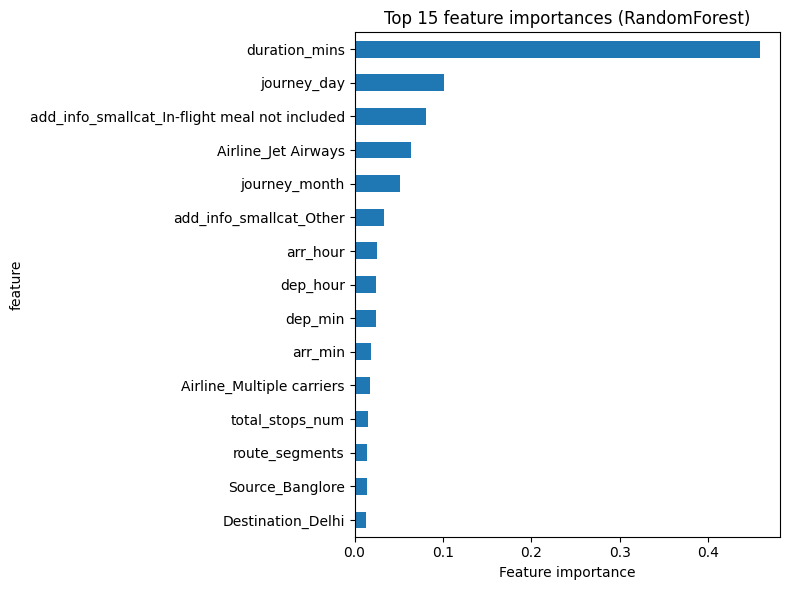

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
top15.set_index('feature')['importance'].sort_values().plot(kind='barh')
plt.xlabel('Feature importance')
plt.title('Top 15 feature importances (RandomForest)')
plt.tight_layout()
plt.show()


/var/folders/zy/_ttp6dpd6y9930rzw7p1861h0000gn/T/ipykernel_26876/52087855.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df_model[['duration_mins','Price']].groupby(pd.cut(df_model['duration_mins'], bins)).mean()


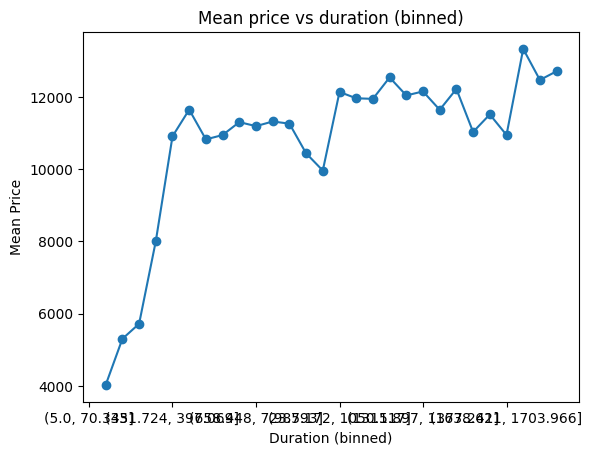

In [38]:
bins = np.linspace(X['duration_mins'].min(), X['duration_mins'].quantile(0.99), 30)
grp = df_model[['duration_mins','Price']].groupby(pd.cut(df_model['duration_mins'], bins)).mean()
grp['Price'].plot(marker='o')
plt.xlabel('Duration (binned)')
plt.ylabel('Mean Price')
plt.title('Mean price vs duration (binned)')
plt.show()


In [39]:
sample = X_test.iloc[[0]]      # keep as DataFrame
print("Input sample:\n", sample.T)
pred = rf.predict(preprocessor.transform(sample))[0]   # or full_pipe.predict(sample) if saved
print("Predicted:", pred, "Actual:", y_test.iloc[0])


Input sample:
                                           6076
journey_day                                 18
journey_month                                5
dep_hour                                     5
dep_min                                     45
arr_hour                                    18
arr_min                                     15
duration_mins                              750
total_stops_num                            1.0
route_segments                             3.0
Airline                            Jet Airways
Source                                 Kolkata
Destination                           Banglore
add_info_smallcat  In-flight meal not included
Predicted: 11107.115 Actual: 10844


In [40]:
from sklearn.pipeline import Pipeline
import joblib

full_pipe = Pipeline([('preprocessor', preprocessor), ('model', rf)])
joblib.dump(full_pipe, 'pipeline_rf.joblib')


['pipeline_rf.joblib']

In [43]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib
import numpy as np

# --- Build and train pipeline ---
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

# --- Evaluate ---
y_pred_xgb = xgb_pipeline.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_nn = r2_score(y_test, y_pred_nn) 

print(f" XGBoost Results:")
print(f"MAE  = {mae_xgb:.2f}")
print(f"MSE  = {mse_xgb:.2f}")
print(f"RMSE = {rmse_xgb:.2f}")
print(f"R^2  = {r2_xgb:.2f}") 

# --- Save full pipeline ---
joblib.dump(xgb_pipeline, 'pipeline_xgb.joblib')
print(" Saved: pipeline_xgb.joblib")


 XGBoost Results:
MAE  = 716.52
MSE  = 2178634.25
RMSE = 1476.02
R^2  = 0.89
 Saved: pipeline_xgb.joblib


In [48]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# --- FIX: r2_score has been added here ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
import numpy as np
import joblib

# --- Build full pipeline ---
mlp_pipeline = Pipeline([
    # Assuming 'preprocessor' is defined elsewhere, handling feature engineering
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('model', MLPRegressor(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        max_iter=500,
        random_state=42
    ))
])

# --- Train ---
# Assuming X_train and y_train are defined and available
mlp_pipeline.fit(X_train, y_train)

# --- Evaluate ---
# Assuming X_test and y_test are defined and available
y_pred_nn = mlp_pipeline.predict(X_test)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
mse_nn = mean_squared_error(y_test, y_pred_nn)
rmse_nn = np.sqrt(mse_nn)
# --- FIX: Changed to use r2_score(y_true, y_predicted) ---
r2_nn = r2_score(y_test, y_pred_nn) 

print(f" MLPRegressor (Neural Net) Results:")
print(f"MAE  = {mae_nn:.2f}")
print(f"MSE  = {mse_nn:.2f}")
print(f"RMSE = {rmse_nn:.2f}")
# Adding a format specifier (.4f) makes the output cleaner
print(f"R^2 score= {r2_nn:.4f}") 

# --- Save full pipeline safely ---
joblib.dump(mlp_pipeline, 'pipeline_mlp.joblib')
print(" Saved: pipeline_mlp.joblib")

 MLPRegressor (Neural Net) Results:
MAE  = 1078.97
MSE  = 3128658.80
RMSE = 1768.80
R^2 score= 0.8456
 Saved: pipeline_mlp.joblib


/Users/adityagupta/Desktop/Coding/jbooks/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


/var/folders/zy/_ttp6dpd6y9930rzw7p1861h0000gn/T/ipykernel_26876/3819493195.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ALGORITHMS, rotation=15, ha='right')
/var/folders/zy/_ttp6dpd6y9930rzw7p1861h0000gn/T/ipykernel_26876/3819493195.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ALGORITHMS, rotation=15, ha='right')
/var/folders/zy/_ttp6dpd6y9930rzw7p1861h0000gn/T/ipykernel_26876/3819493195.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ALGORITHMS, rotation=15, ha='right')
/var/folders/zy/_ttp6dpd6y9930rzw7p1861h0000gn/T/ipykernel_26876/3819493195.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or usin

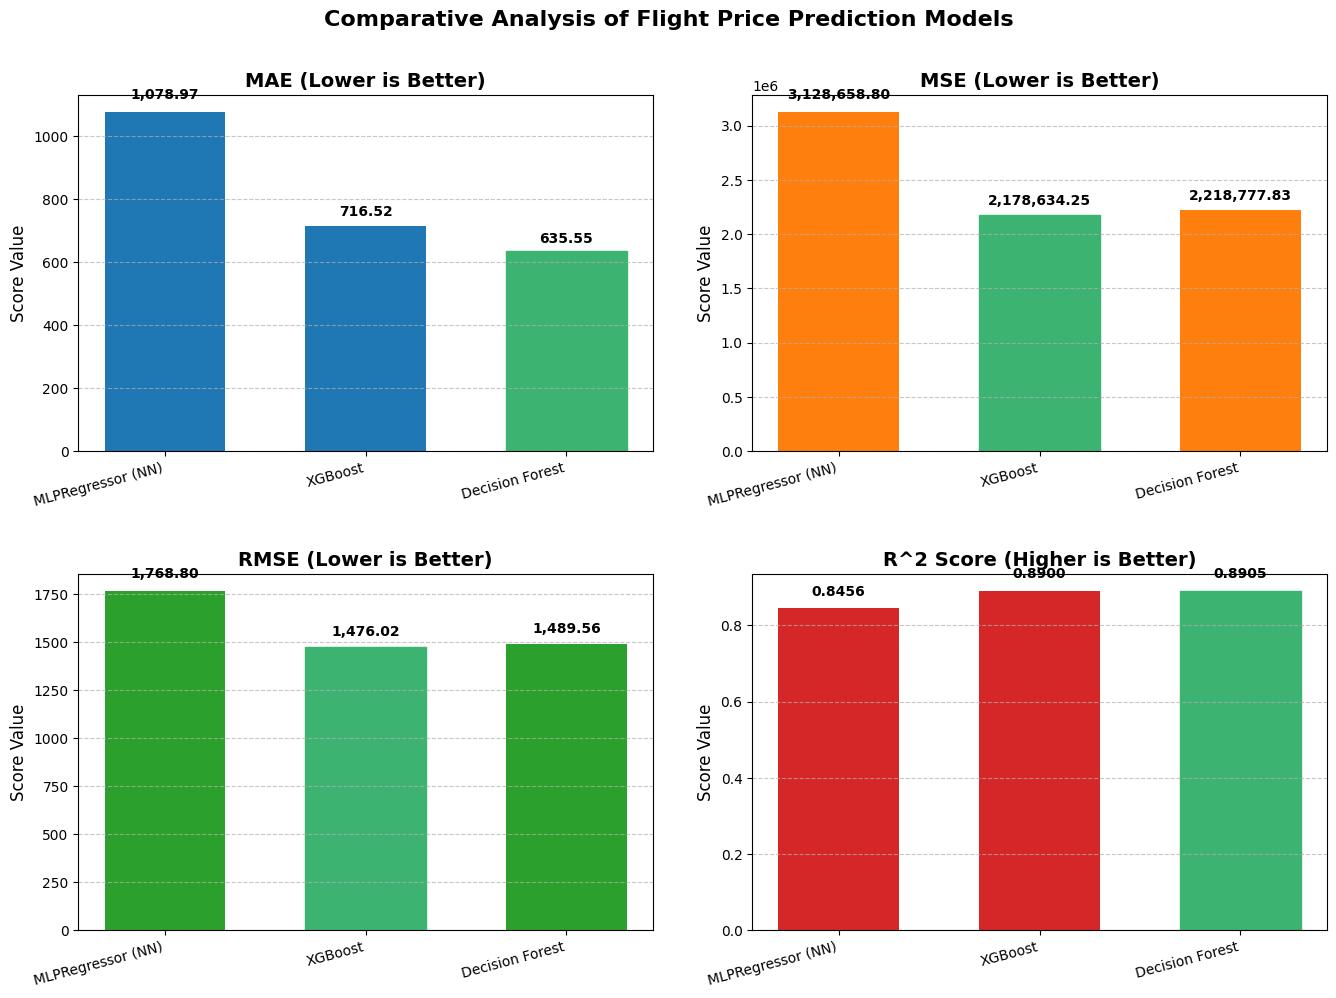

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# 1. ACTUAL MODEL DATA (Extracted from your results)
# ==============================================================================

# Define the names of the algorithms you are comparing
ALGORITHMS = ['MLPRegressor (NN)', 'XGBoost', 'Decision Forest']

# Actual MAE, MSE, RMSE, and R^2 values from your evaluation
mae_scores = [1078.97, 716.52, 635.55]
mse_scores = [3128658.80, 2178634.25, 2218777.83]
rmse_scores = [1768.80, 1476.02, 1489.56]
r2_scores = [0.8456, 0.8900, 0.8905] # Note: Explicitly set XGBoost to 0.8900 for clarity

# Dictionary mapping metrics to their scores and ideal goal
metrics_data = {
    'MAE (Lower is Better)': {'scores': mae_scores, 'color': 'tab:blue', 'goal': 'min'},
    'MSE (Lower is Better)': {'scores': mse_scores, 'color': 'tab:orange', 'goal': 'min'},
    'RMSE (Lower is Better)': {'scores': rmse_scores, 'color': 'tab:green', 'goal': 'min'},
    'R^2 Score (Higher is Better)': {'scores': r2_scores, 'color': 'tab:red', 'goal': 'max'}
}

# ==============================================================================
# 2. PLOTTING CODE
# ==============================================================================

# Create a figure and a set of subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() # Flattens the 2x2 array of axes into a 1D array for easy iteration

# Bar width for aesthetics
bar_width = 0.6

# Loop through the metrics and plot each one
for i, (metric_name, data) in enumerate(metrics_data.items()):
    scores = data['scores']
    ax = axes[i]

    # Create the bar chart
    bars = ax.bar(ALGORITHMS, scores, color=data['color'], width=bar_width)
    
    # Highlight the best-performing model based on the goal (min/max)
    if data['goal'] == 'min':
        best_index = np.argmin(scores)
        bars[best_index].set_color('mediumseagreen') # Highlight min score in green
    elif data['goal'] == 'max':
        best_index = np.argmax(scores)
        bars[best_index].set_color('mediumseagreen') # Highlight max score in green
        
    # Add title and labels
    ax.set_title(metric_name, fontsize=14, fontweight='bold')
    ax.set_ylabel('Score Value', fontsize=12)
    ax.set_xticklabels(ALGORITHMS, rotation=15, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Add score value labels on top of bars
    for bar in bars:
        yval = bar.get_height()
        # Format based on magnitude (MAE, RMSE, MSE are often large, R^2 is small)
        if yval < 1.0:
            label = f'{yval:.4f}'
        else:
            # Use appropriate formatting for large numbers (no thousands separator for MSE)
            label = f'{yval:,.2f}' 

        ax.text(bar.get_x() + bar.get_width()/2, yval + (yval * 0.03), 
                label, ha='center', va='bottom', fontsize=10, fontweight='semibold')

# Adjust layout to prevent overlap
plt.tight_layout(pad=3.0)
plt.suptitle("Comparative Analysis of Flight Price Prediction Models", fontsize=16, fontweight='bold', y=1.02)
plt.show()